In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array


In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [0]:
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs


In [0]:
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	#re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	#table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			#line = normalize('NFD', line).encode('ascii', 'ignore')
			#line = line.decode('UTF-8')
			# tokenize on white space
			#line = line.split()
			# convert to lowercase
			#line = [word.lower() for word in line]
			# remove punctuation from each token
			#line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			#line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			#line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)

In [0]:

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)


In [0]:

# load dataset
filename = '/content/gdrive/My Drive/Neural Machine Translation/English-Hindi-10000.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-hindi.pkl')
# spot check
for i in range(100):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))



Saved: english-hindi.pkl
[W e   g e n e r a l l y   f i n d   t h i s   c a p a c i t y   b e i n g   d i r e c t e d   t o w a r d s   m u n d a n e   o b j e c t s   a n d   c l o s e   r e l a t i o n s   l i k e   w i v e s   ,   c h i l d r e n   a n d   f r i e n d s   .] => [प ् र ा य ः   ह म   इ स   भ ं ड ा र   क ो   ल ौ क ि क   व ि ष य ो ं   प र   औ र   प त ् न ी   ,   प ु त ् र   म ि त ् र   आ द ि   स ग े   स ं ब ं ध ि य ो ं   प र   प ् र व र ् त ि त   क र   द े त े   ह ै ं   ।  ]
[I   '   m   s u r e   I   '   l l   m a k e   a   c a r e l e s s   m i s t a k e   .] => [म ु झ े   ज न त ा   ह ू ँ   क ी   म ै ं   इ स   व ी ड ि य ो   म े ं   क ि स ी   भ ी   स म य]
[D i s p l a y   w e b   b r o w s e r   h e l p   .] => [व े ब   ब ् र ा उ ज ़ र   म द द   द ि ख ा ए ँ]
[I t   i s   o u t   o f   H i s   M e r c y   t h a t   H e   h a s   m a d e   f o r   y o u   N i g h t   a n d   D a y   ,   -   t h a t   y e   m a y   r e s t   t h e r e i n   ,   a n d   t h a t   y e   m a

In [0]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle


In [0]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)


In [0]:
raw_dataset = load_clean_sentences('english-hindi.pkl')

# reduce dataset size
n_sentences = 10000
#n_sentences=50000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:7000], dataset[7000:]
#train, test = dataset[:45000], dataset[45000:]
# save
save_clean_data(dataset, 'english-hindi-both.pkl')
save_clean_data(train, 'english-hindi-train.pkl')
save_clean_data(test, 'english-hindi-test.pkl')

Saved: english-hindi-both.pkl
Saved: english-hindi-train.pkl
Saved: english-hindi-test.pkl


In [0]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [0]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X


In [0]:
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y


In [0]:
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model


In [0]:
# load datasets
dataset = load_clean_sentences('english-hindi-both.pkl')
train = load_clean_sentences('english-hindi-train.pkl')
test = load_clean_sentences('english-hindi-test.pkl')


In [0]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare Hindi tokenizer
hin_tokenizer = create_tokenizer(dataset[:, 1])
hin_vocab_size = len(hin_tokenizer.word_index) + 1
hin_length = max_length(dataset[:, 1])
print('Hindi Vocabulary Size: %d' % hin_vocab_size)
print('Hindi Max Length: %d' % (hin_length))


English Vocabulary Size: 88
English Max Length: 1871
Hindi Vocabulary Size: 184
Hindi Max Length: 1590


In [0]:
# prepare training data
trainX = encode_sequences(hin_tokenizer, hin_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(hin_tokenizer, hin_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)


In [0]:

# define model
model = define_model(hin_vocab_size, eng_vocab_size, hin_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
# summarize defined model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1590, 256)         47104     
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1871, 256)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1871, 256)         525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1871, 88)          22616     
Total params: 1,120,344
Trainable params: 1,120,344
Non-trainable params: 0
_________________________________________________________________
None


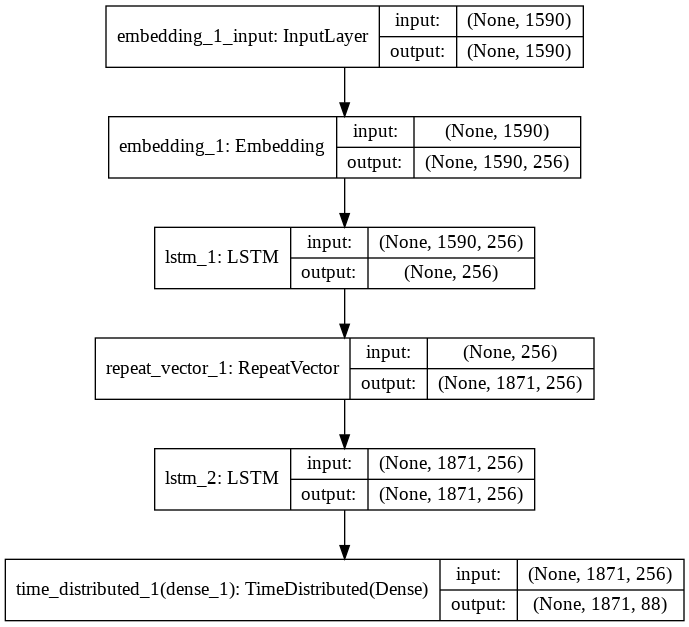

In [0]:
plot_model(model, to_file='model.png', show_shapes=True)

In [0]:
# fit model
import os
import tensorflow as tf
import keras
'''
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=15, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)
'''
checkpoint_path = "gdrive/My Drive/Neural Machine Translation/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
                                                
model.fit(trainX, trainY, epochs=15, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)


Train on 7000 samples, validate on 2999 samples
Epoch 1/15
 - 1017s - loss: 0.3098 - val_loss: 0.3169

Epoch 00001: val_loss improved from inf to 0.31695, saving model to gdrive/My Drive/Neural Machine Translation/cp.ckpt
Epoch 2/15
 - 1004s - loss: 0.3293 - val_loss: 0.3657

Epoch 00002: val_loss did not improve from 0.31695
Epoch 3/15
 - 1002s - loss: 0.3262 - val_loss: 0.3154

Epoch 00003: val_loss improved from 0.31695 to 0.31540, saving model to gdrive/My Drive/Neural Machine Translation/cp.ckpt
Epoch 4/15
 - 1003s - loss: 0.3188 - val_loss: 0.3170

Epoch 00004: val_loss did not improve from 0.31540
Epoch 5/15
 - 997s - loss: 0.3319 - val_loss: 0.3165

Epoch 00005: val_loss did not improve from 0.31540
Epoch 6/15
 - 1001s - loss: 0.3173 - val_loss: 0.3201

Epoch 00006: val_loss did not improve from 0.31540
Epoch 7/15
 - 995s - loss: 0.3190 - val_loss: 0.3179

Epoch 00007: val_loss did not improve from 0.31540
Epoch 8/15
 - 1000s - loss: 0.3200 - val_loss: 0.3169

Epoch 00008: val_

KeyboardInterrupt: ignored

In [0]:
import numpy
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu


In [0]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X


In [0]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)


In [0]:

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
    temp_dataset=raw_dataset
    numpy.delete(temp_dataset,2,axis=1)
    print(temp_dataset)
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
		# translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        #(raw_dataset)
        #raw_target, raw_src = temp_dataset[i]
        raw_target=temp_dataset[i][0]
        raw_src=temp_dataset[i][1]
        if i < 100:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append([raw_target.split()])
        predicted.append(translation.split())
	# calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


In [0]:
model = load_model('gdrive/My Drive/Neural Machine Translation/cp.ckpt')

In [0]:
print(train)

[["T h e   d u t y   o f   p u b l i c   m e n   o f   s t a n d i n g   i s   ,   a s   I   h a v e   m a d e   i t   c l e a r   t o   C o n g r e s s m e n   v i s i t i n g   m e   '   w i t h   s u c h   v a g u e   i m p u t a t i o n s   ,   t o   e x p o s e   s u c h   m e n   a n d   t o   l e a d   c o n c r e t e   e v i d e n c e   t o   p r o v e   t h e i r   c o n t e n t i o n s   ."
  'प ् र त ि ष ् ठ ि त   ज न स े व क ो ं   क ा   क र ् त व ् य   य ह   ह ै   ,   ज ै स ा   क ि   म ै ं न े   अ प न े   प ा स   ऐ स े   अ स ् प ष ् ट   अ र ो प ो ं   क े   स ा थ   आ न े   व ा ल े   क ा ं ग ् र े स   -   ज न ो ं   स े   स ् प ष ् ट   क ह ा   ह ै   क ि   व े   ऐ स े   आ द म ि य ो ं   क ा   भ ं ड ़ ा फ ो ड ़   क र े ं   औ र   अ प न े   आ र ो प ो ं   क ो   स ि द ् ध   क र न े   क े   ल ि ए   ठ ो स   स ब ू त   प े श   क र े ं   ।  ']
 ['A u t h e n t i c a t i o n   f a i l e d   f o r   a c c o u n t   %   s   .'
  'ख ा त ा   क े   ल ि ए   स त ् य ा प न   अ स फ ल']
 ['S i n c e

In [0]:
evaluate_model(model, eng_tokenizer, trainX, train)

IndexError: ignored

In [0]:
print()

[["S A R D A R   T O   W A V E L L   ,   D A T E D   2 0   O C T O B E R   1 9 4 6   R a j a   G h a z a n f a r   A l i   K h a n   '   s   s p e e c h   c o p y   h e r e w i t h   -   S e r i a l   N o   .   2 0   i s   d i s c o n c e r t i n g   a n d   b o d e s   i l l   f o r   t h e   f u t u r e   ."
  '1 9   .   स र द ा र   क ा   प त ् र   ल ॉ र ् ड   व े व े ल   क ो   त ा   .   2 0   -   1 0   -   1 9 4 6   र ा ज ा   ग ज न फ र   अ ल ी   ख ा न   क ा   भ ा ष ण   ज ि स क ी   प ् र त ि   स ं ल ग ् न   ह ै   -   न ं   .   2 0   व ् य ा क ु ल   औ र   अ श ा ं त   ब न ा   द े न े   व ा ल ा   ह ै   औ र   अ श ु भ   भ व ि ष ् य   क ा   स ू च क   ह ै   ।  ']
 ['T h a t   w h i c h   W e   h a v e   r e v e a l e d   t o   y o u   o f   t h e   B o o k   i s   t h e   t r u t h   ,   c o n f i r m i n g   w h a t   w a s   b e f o r e   i t   .   I n d e e d   A l l a h   i s   a l l   -   a w a r e   ,   a l l   -   s e e i n g   a b o u t   H i s   s e r v a n t s   .'
  "औ र   ह म न 

In [0]:

evaluate_model(model, eng_tokenizer, testX, test)

IndexError: ignored

In [0]:
temp_dataset=train
#numpy.delete(temp_dataset,2,axis=1)
print(temp_dataset)
actual, predicted = list(), list()
for i, source in enumerate(trainX):
		# translate encoded source text
  source = source.reshape((1, source.shape[0]))
  translation = predict_sequence(model, eng_tokenizer, source)
        #(raw_dataset)
        #raw_target, raw_src = temp_dataset[i]
  raw_target=temp_dataset[i][0]
  raw_src=temp_dataset[i][1]
  if i < 10:
    print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
  actual.append([raw_target.split()])
  predicted.append(translation.split())
	# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

[["T h e   d u t y   o f   p u b l i c   m e n   o f   s t a n d i n g   i s   ,   a s   I   h a v e   m a d e   i t   c l e a r   t o   C o n g r e s s m e n   v i s i t i n g   m e   '   w i t h   s u c h   v a g u e   i m p u t a t i o n s   ,   t o   e x p o s e   s u c h   m e n   a n d   t o   l e a d   c o n c r e t e   e v i d e n c e   t o   p r o v e   t h e i r   c o n t e n t i o n s   ."
  'प ् र त ि ष ् ठ ि त   ज न स े व क ो ं   क ा   क र ् त व ् य   य ह   ह ै   ,   ज ै स ा   क ि   म ै ं न े   अ प न े   प ा स   ऐ स े   अ स ् प ष ् ट   अ र ो प ो ं   क े   स ा थ   आ न े   व ा ल े   क ा ं ग ् र े स   -   ज न ो ं   स े   स ् प ष ् ट   क ह ा   ह ै   क ि   व े   ऐ स े   आ द म ि य ो ं   क ा   भ ं ड ़ ा फ ो ड ़   क र े ं   औ र   अ प न े   आ र ो प ो ं   क ो   स ि द ् ध   क र न े   क े   ल ि ए   ठ ो स   स ब ू त   प े श   क र े ं   ।  ']
 ['A u t h e n t i c a t i o n   f a i l e d   f o r   a c c o u n t   %   s   .'
  'ख ा त ा   क े   ल ि ए   स त ् य ा प न   अ स फ ल']
 ['S i n c e